In [1]:
import os
from PIL import Image
import random
import string

from einops import rearrange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.nn import functional as F

%matplotlib inline

In [2]:
CHAR_SET = list(string.ascii_lowercase) + [' ']
MAX_TURNS = 3
MAX_OUTPUT_LENGTH = 64
IMG_DIM = (3, 256, 256) # (3, 224, 224)

In [3]:
# Source: https://discuss.pytorch.org/t/list-of-nn-module-in-a-nn-module/219/2
# Use this over normal list or layers don't get registered
class ListModule(nn.Module):
    def __init__(self, *args):
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)

In [4]:
# https://discuss.pytorch.org/t/how-to-load-images-without-using-imagefolder/59999
class ImgDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)
        self.img_cache = [None] * len(self.all_imgs)

    def shuffle(self):
        zipped_items = list(zip(self.all_imgs, self.img_cache))
        random.shuffle(zipped_items)
        self.all_imgs, self.img_cache = zip(*zipped_items)
        self.all_imgs = list(self.all_imgs)
        self.img_cache = list(self.img_cache)
        
    def get_batch_iter(self, batch_size):
        for i in range(0, len(self.all_imgs), batch_size):
            yield self[i:i+batch_size]
        
    def __len__(self):
        return len(self.all_imgs)

    def _load_img(self, idx):
        if self.img_cache[idx] is not None:
            return self.img_cache[idx]
        
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert('RGB')
        tensor_img = self.transform(image)
        self.img_cache[idx] = tensor_img
        
        return tensor_img
    
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self._load_img(idx)
        elif isinstance(idx, slice):
            start = idx.start or 0
            end = idx.stop or len(self.all_imgs)
            step = idx.step or 1
            
            if start < 0:
                start = len(self.all_imgs) + start
            if end < 0:
                end = len(self.all_imgs) + end
            end = min(end, len(self.all_imgs))
            
            imgs = []
            for i in range(start, end, step):
                iter_img = self._load_img(i).unsqueeze(0)
                imgs.append(iter_img)
            imgs_tensor = torch.cat(imgs, dim=0)
            return imgs_tensor
    
def display_img(img):
    plt.imshow(img.permute(1, 2, 0))
    
def make_dataset(path):
    crop_size = IMG_DIM[1]
    transform = transforms.Compose([
       transforms.Resize(crop_size),
       transforms.CenterCrop(crop_size),
       transforms.ToTensor()
    ])

    return ImgDataSet(path, transform)

In [5]:
# # reconstruction loss

# recon_loss = self.loss_fn(img, out)

# # kl divergence

# logits = rearrange(logits, 'b n h w -> b (h w) n')
# log_qy = F.log_softmax(logits, dim = -1)
# log_uniform = torch.log(torch.tensor([1. / num_tokens], device = device))
# kl_div = F.kl_div(log_uniform, log_qy, None, None, 'batchmean', log_target = True)

# loss = recon_loss + (kl_div * kl_div_loss_weight)

In [6]:
dataset = make_dataset('data/')

In [7]:
class ResidualBlock(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, n_filters, kernel_size=3):
        super().__init__()

        if kernel_size % 2 == 0:
            raise ValueError('Residual blocks must use and odd kernel size!')

        self.n_filters = n_filters
        padding = int(kernel_size // 2)

        self.conv1 = nn.Conv2d(n_filters, n_filters, kernel_size, 1, padding)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size, 1, padding)

        self.batch_norm1 = nn.BatchNorm2d(n_filters)
        self.batch_norm2 = nn.BatchNorm2d(n_filters)

    def forward(self, x):
        # Convolution 1
        z = self.batch_norm1(x)
        z = F.relu(z)
        z = self.conv1(z)

        # Convolution 2
        z = self.batch_norm2(z)
        z = F.relu(z)
        z = self.conv2(z)
        z += x

        return z

In [8]:
class Encoder(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.img_dim = img_dim
        
        input_filter_count = 2 * img_dim[0]
        
        self.downsampling_layer1 = nn.Sequential(
                nn.Conv2d(input_filter_count, 32, 4, stride=2, padding=1),
                nn.ReLU())
        self.downsampling_layer2 = nn.Sequential(
                nn.Conv2d(32, 32, 4, stride=2, padding=1),
                nn.ReLU())
        self.downsampling_layer3 = nn.Sequential(
                nn.Conv2d(32, 64, 4, stride=2, padding=1),
                nn.ReLU())
        self.downsampling_layer4 = nn.Sequential(
                nn.Conv2d(64, 64, 4, stride=2, padding=1),
                nn.ReLU())
        self.downsampling_layer5 = nn.Sequential(
                nn.Conv2d(64, 128, 4, stride=2, padding=1),
                nn.ReLU())
        
        self.res_block = ResidualBlock(128)
        
        self.conv_layer = nn.Conv2d(128, len(CHAR_SET), 1)
        
    def forward(self, target_img, curr_img):
        full_input = torch.cat([target_img, curr_img], dim=1)
        
        z = self.downsampling_layer1(full_input)
        z = self.downsampling_layer2(z)
        z = self.downsampling_layer3(z)
        z = self.downsampling_layer4(z)
        z = self.downsampling_layer5(z)
        z = self.res_block(z)
        logits = self.conv_layer(z)
        one_hot_tokens = F.gumbel_softmax(logits, hard=True)
        
        return one_hot_tokens

In [9]:
class Decoder(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.img_dim = img_dim
        self.embeddings_dim = 64
        assert img_dim[1] == img_dim[2], 'Only supports square imgs!'
    
        self.embeddings_layer = nn.Sequential(
            nn.Conv2d(len(CHAR_SET), self.embeddings_dim, 1),
            nn.Tanh())
        
        self.res_block = ResidualBlock(self.embeddings_dim)
        
        self.upsampling_layer1 = nn.Sequential(
                nn.ConvTranspose2d(self.embeddings_dim, 128, 4, stride=2),
                nn.ReLU())
        self.upsampling_layer2 = nn.Sequential(
                nn.ConvTranspose2d(128, 64, 4, stride=2),
                nn.ReLU())
        self.upsampling_layer3 = nn.Sequential(
                nn.ConvTranspose2d(64, 64, 4, stride=2),
                nn.ReLU())
        self.upsampling_layer4 = nn.Sequential(
                nn.ConvTranspose2d(64, 32, 4, stride=2),
                nn.ReLU())
        self.upsampling_layer5 = nn.Sequential(
                nn.ConvTranspose2d(32, 32, 4, stride=2),
                nn.ReLU())
        self.upsampling_layer6 = nn.Sequential(
            nn.Upsample(img_dim[1]),
            nn.Conv2d(32, 4, 3, padding=1),
            nn.ReLU())
        
        self.change_res_block = ResidualBlock(3)
        self.activation_res_block = ResidualBlock(1)
        
        self.change_conv_layer = nn.Sequential(
            nn.Conv2d(3, 3, 1),
            nn.Tanh())
        self.activation_conv_layer = nn.Sequential(
            nn.Conv2d(1, 1, 1),
            nn.Sigmoid())
         
    def forward(self, descriptions):
        z = self.embeddings_layer(descriptions)
        z = self.res_block(z)
        z = self.upsampling_layer1(z)
        z = self.upsampling_layer2(z)
        z = self.upsampling_layer3(z)
        z = self.upsampling_layer4(z)
        z = self.upsampling_layer5(z)
        z = self.upsampling_layer6(z)
        
        change_z = z[:, :3]
        activation_z = z[:, 3:4]
        
        change_z = self.change_res_block(change_z)
        change_z = self.change_conv_layer(change_z)
        
        activation_z = self.activation_res_block(activation_z)
        activation_z = self.activation_conv_layer(activation_z)
        
        output = change_z * activation_z
        
        return output

In [10]:
encoder = Encoder(IMG_DIM)
test_img = torch.rand((2, 3, 64, 64))
logits = encoder(test_img, test_img)
print(logits.shape)
decoder = Decoder(IMG_DIM)
out_img = decoder(logits)
print(out_img.shape)

torch.Size([2, 27, 2, 2])
torch.Size([2, 3, 256, 256])


In [97]:
# Training params
n_epochs = 50
batch_size = 32
log_freq = 100
lr = 2e-5
min_steps = 1
max_steps = 3

In [18]:
encoder = Encoder(IMG_DIM).cuda()
decoder = Decoder(IMG_DIM).cuda()

In [19]:
# import gc
# del encoder
# del decoder
# gc.collect()
# torch.cuda.empty_cache()

In [20]:
# encoder = torch.load('encoder_v4.model')
# decoder = torch.load('decoder_v4.model')

In [98]:
loss_func = nn.MSELoss()
model_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(model_params, lr=lr)
loss_hist = {x: [] for x in range(min_steps, max_steps+1)}

In [99]:
for epoch in range(n_epochs):
    dataset.shuffle()
    data_iter = dataset.get_batch_iter(batch_size)
    log_loss_steps = 0
    for batch_idx, orig_img_batch in enumerate(data_iter):

        # Prep data
        orig_img_batch = orig_img_batch.cuda()
        curr_img_batch = torch.zeros_like(orig_img_batch)
        
        for step in range(max_steps):
            optimizer.zero_grad()

            logits = encoder(orig_img_batch, curr_img_batch)
            gen_img_batch = torch.clamp(decoder(logits) + curr_img_batch.detach(), 0, 1)
            curr_img_batch = gen_img_batch.detach()

            # Calculate loss and update weights
            loss = loss_func(gen_img_batch, orig_img_batch)
            loss_hist[step+1].append(loss.item())
            log_loss_steps += 1
            loss.backward()
            optimizer.step()
        
        # Ocasionally print losses
        if (batch_idx + 1) % log_freq == 0:
            min_step_loss = np.mean(loss_hist[min_steps][-log_freq:])
            max_step_loss = np.mean(loss_hist[max_steps][-log_freq:])
            log_loss_steps = 0
            print('Epoch #{} batch #{} | Avg step {} loss: {:.4f} | Avg step {} loss: {:.4f}'.format(
                epoch+1, batch_idx+1, min_steps, min_step_loss, max_steps, max_step_loss))

Epoch #1 batch #100 | Avg step 1 loss: 0.0218 | Avg step 3 loss: 0.0150
Epoch #1 batch #200 | Avg step 1 loss: 0.0217 | Avg step 3 loss: 0.0150
Epoch #2 batch #100 | Avg step 1 loss: 0.0217 | Avg step 3 loss: 0.0149
Epoch #2 batch #200 | Avg step 1 loss: 0.0216 | Avg step 3 loss: 0.0150
Epoch #3 batch #100 | Avg step 1 loss: 0.0216 | Avg step 3 loss: 0.0149
Epoch #3 batch #200 | Avg step 1 loss: 0.0217 | Avg step 3 loss: 0.0150
Epoch #4 batch #100 | Avg step 1 loss: 0.0218 | Avg step 3 loss: 0.0151
Epoch #4 batch #200 | Avg step 1 loss: 0.0215 | Avg step 3 loss: 0.0147
Epoch #5 batch #100 | Avg step 1 loss: 0.0217 | Avg step 3 loss: 0.0149
Epoch #5 batch #200 | Avg step 1 loss: 0.0216 | Avg step 3 loss: 0.0149
Epoch #6 batch #100 | Avg step 1 loss: 0.0215 | Avg step 3 loss: 0.0149
Epoch #6 batch #200 | Avg step 1 loss: 0.0218 | Avg step 3 loss: 0.0150
Epoch #7 batch #100 | Avg step 1 loss: 0.0215 | Avg step 3 loss: 0.0148
Epoch #7 batch #200 | Avg step 1 loss: 0.0216 | Avg step 3 loss:

KeyboardInterrupt: 

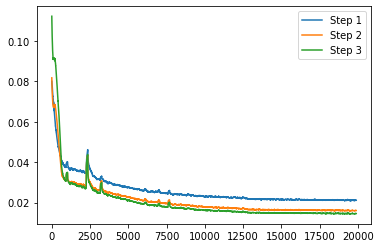

In [100]:
def smooth_seq(seq, window=100):
    new_seq = []
    for i in range(0, len(seq)-window):
        new_seq.append(np.mean(seq[i:i+window]))
    return new_seq

for step, losses in loss_hist.items():
    smoothed_losses = smooth_seq(losses)
    plt.plot(smoothed_losses, label='Step {}'.format(step))
plt.legend()

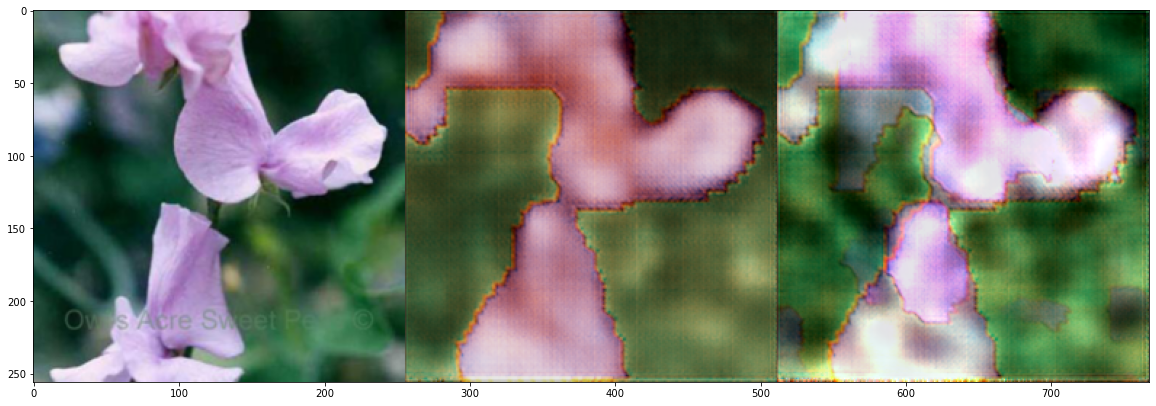

In [149]:
test_batch_size = 1

dataset.shuffle()
data_iter = dataset.get_batch_iter(test_batch_size)
orig_img_batch = next(data_iter).cuda()

# Prep data
curr_img_batch = torch.zeros_like(orig_img_batch)

gen_imgs = []
for step in range(max_steps):
    logits = encoder(orig_img_batch, curr_img_batch)
    gen_img_batch = torch.clamp(decoder(logits) + curr_img_batch.detach(), 0, 1)
    curr_img_batch = gen_img_batch.detach()
    gen_imgs.append(gen_img_batch[0].detach().cpu())
    curr_img_batch = gen_img_batch.detach()

# logits = encoder(orig_img_batch, orig_img_batch)
# gen_img_batch = decoder(logits)
plt.figure(figsize=(20,20))
combined_img = torch.cat([orig_img_batch[0].cpu(), gen_imgs[0], gen_imgs[-1]], axis=2)
display_img(combined_img)

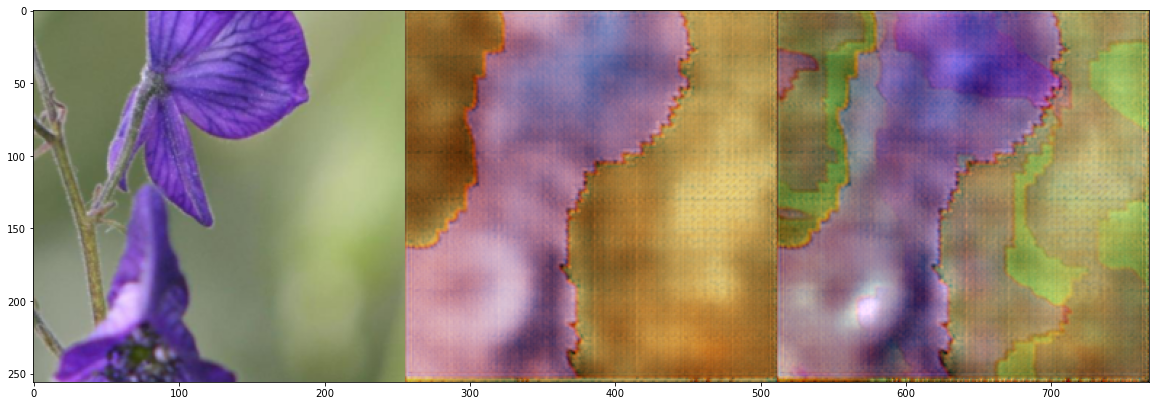

In [112]:
plt.figure(figsize=(20,20))
combined_img = torch.cat([orig_img_batch[0].cpu(), gen_imgs[0], gen_imgs[-1]], axis=2)
display_img(combined_img)

In [150]:
with open('encoder_final.model', 'wb') as f:
    torch.save(encoder, f)
    
with open('decoder_final.model', 'wb') as f:
    torch.save(decoder, f)